## Focusing on terse `FeatNets` training/eval

In [4]:
import os, sys
import copy as copyroot
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
from fastai2.basics import *
from fastai2.vision.all import *
%load_ext autoreload
%autoreload 2

from module.mnist_helpers import build_df, eda_fig_1, build_dls
from module.mnist_models import FeatsNet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
dls = build_dls(target='topleft')
x, y = dls.one_batch()
x.shape

torch.Size([64, 1, 28, 28])

In [7]:
fn = FeatsNet(feats=['pix', 'pts12'])
learn = Learner(dls, fn, loss_func=MSELossFlat())
learn.fit(10)

epoch,train_loss,valid_loss,time
0,0.094428,0.037222,00:02
1,0.069161,0.041445,00:02
2,0.055214,0.027107,00:02
3,0.045507,0.024621,00:02
4,0.039211,0.021651,00:02
5,0.034100,0.019174,00:02
6,0.030302,0.019316,00:02
7,0.027292,0.017713,00:02
8,0.024712,0.017045,00:02
9,0.022654,0.016954,00:02


In [11]:
fn = FeatsNet(feats=['pts12'])
learn = Learner(dls, fn, loss_func=MSELossFlat())
learn.fit(10)

epoch,train_loss,valid_loss,time
0,0.329072,0.240227,00:02
1,0.254424,0.131029,00:02
2,0.196408,0.068816,00:02
3,0.154329,0.042165,00:02
4,0.124711,0.034464,00:02
5,0.104310,0.033118,00:02
6,0.089793,0.033119,00:02
7,0.079026,0.032382,00:02
8,0.070836,0.031210,00:02
9,0.064115,0.030039,00:02


In [12]:
fn = FeatsNet(feats=['pts11'])
learn = Learner(dls, fn, loss_func=MSELossFlat())
learn.fit(10)

epoch,train_loss,valid_loss,time
0,0.226133,0.191506,00:02
1,0.199945,0.148894,00:02
2,0.176102,0.114228,00:02
3,0.154513,0.087028,00:02
4,0.135947,0.066887,00:02
5,0.119410,0.053080,00:02
6,0.105294,0.044324,00:02
7,0.093371,0.039019,00:02
8,0.083694,0.036169,00:02
9,0.076082,0.034799,00:02


In [13]:
fn = FeatsNet(feats=['pts11', 'pts12', 'pts22'])
learn = Learner(dls, fn, loss_func=MSELossFlat())
learn.fit(10)

epoch,train_loss,valid_loss,time
0,0.138045,0.070941,00:03
1,0.093848,0.035473,00:03
2,0.073019,0.033947,00:03
3,0.062719,0.034289,00:03
4,0.056222,0.030328,00:03
5,0.050521,0.027266,00:03
6,0.045927,0.025666,00:03
7,0.042177,0.024513,00:03
8,0.039040,0.023308,00:03
9,0.036320,0.021985,00:03


### Look at Relu

In [59]:
flat = nn.Flatten()
relu = nn.ReLU()
lin1 = nn.Linear(in_features=28**2, out_features=50)

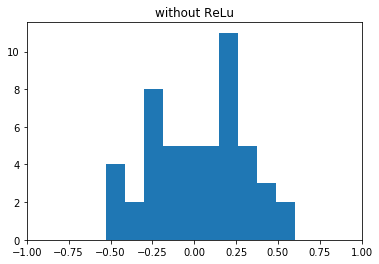

In [67]:
out1 = lin1(flat(x[0]))

plt.hist(out1.detach().flatten());
plt.xlim(-1.,1.)
plt.title('without ReLu');

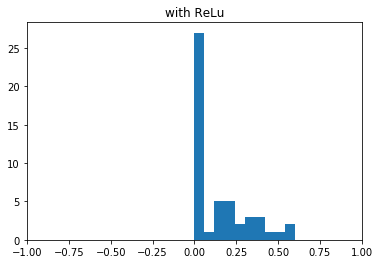

In [71]:
out2 = relu(lin1(flat(x[0])))

plt.hist(out2.detach().flatten());
plt.xlim(-1.,1.)
plt.title('with ReLu');

### BaseNet

In [17]:
class BaseNet(torch.nn.Module):
    def __init__(self, D_in=28, H=28, b_relu=False, b_mid=False):
        super(BaseNet, self).__init__()
        self.b_relu = b_relu
        self.b_mid  = b_mid
        
        self.flat     = nn.Flatten()
        self.linear1  = nn.Linear(in_features=D_in**2, out_features=H)
        self.relu     = nn.ReLU()
        self.linear1a = nn.Linear(in_features=H, out_features=H)
        self.linear2  = nn.Linear(in_features=H, out_features=2, bias=False)
        self.sig      = SigmoidRange(-1., 1)
    
    def forward(self, x):
        
        l0 = self.flat(x)
        l1 = self.linear1(l0)

        if self.b_relu:      l1 = self.relu(l1)
        if self.b_mid:       l1 = self.linear1a(l1)
        if self.b_mid and self.b_relu:  
                             l1 = self.relu(l1)

        l2 = self.linear2(l1)
        y =  self.sig(l2)
        return y


In [20]:
bn = BaseNet(b_relu=False, b_mid=False)
learn_bn = Learner(dls, bn, loss_func=MSELossFlat() )
learn_bn.fit(8)

epoch,train_loss,valid_loss,time
0,0.088308,0.034979,00:01
1,0.062971,0.040873,00:01
2,0.051863,0.029630,00:01
3,0.043407,0.024712,00:01
4,0.037509,0.024635,00:01
5,0.033070,0.021415,00:01
6,0.029656,0.021474,00:01
7,0.026981,0.020865,00:01


In [21]:
bn = BaseNet(b_relu=True, b_mid=False)
learn_bn = Learner(dls, bn, loss_func=MSELossFlat() )
learn_bn.fit(8)

epoch,train_loss,valid_loss,time
0,0.135725,0.048507,00:01
1,0.086116,0.040667,00:01
2,0.068733,0.034633,00:01
3,0.056620,0.027000,00:01
4,0.047974,0.025265,00:01
5,0.042075,0.024538,00:01
6,0.037453,0.022317,00:01
7,0.033733,0.022934,00:01


In [22]:
bn = BaseNet(b_relu=False, b_mid=True)
learn_bn = Learner(dls, bn, loss_func=MSELossFlat() )
learn_bn.fit(8)

epoch,train_loss,valid_loss,time
0,0.129657,0.038138,00:01
1,0.083215,0.043516,00:01
2,0.066492,0.034138,00:01
3,0.054368,0.025799,00:01
4,0.045993,0.026064,00:01
5,0.040353,0.023777,00:01
6,0.035928,0.023435,00:01
7,0.032387,0.021672,00:01


In [23]:
bn = BaseNet(b_relu=True, b_mid=True)
learn_bn = Learner(dls, bn, loss_func=MSELossFlat() )
learn_bn.fit(8)

epoch,train_loss,valid_loss,time
0,0.211481,0.141834,00:01
1,0.149834,0.047194,00:01
2,0.109678,0.038822,00:01
3,0.089756,0.037287,00:01
4,0.076698,0.036298,00:01
5,0.067222,0.032329,00:01
6,0.059957,0.029751,00:01
7,0.054081,0.028530,00:01


In [24]:
learn_bn.fit(12)

epoch,train_loss,valid_loss,time
0,0.029359,0.027433,00:01
1,0.027883,0.025842,00:01
2,0.026975,0.025347,00:01
3,0.025598,0.024063,00:01
4,0.024343,0.023367,00:01
5,0.023316,0.022833,00:01
6,0.022441,0.022555,00:01
7,0.021471,0.021564,00:01
8,0.020408,0.021209,00:01
9,0.019567,0.020321,00:01


In [25]:
learn_bn.fit(10)

epoch,train_loss,valid_loss,time
0,0.014454,0.019642,00:01
1,0.013946,0.018867,00:01
2,0.013797,0.020232,00:01
3,0.013407,0.018594,00:01
4,0.013095,0.018658,00:01
5,0.012758,0.018357,00:01
6,0.012419,0.018102,00:01
7,0.012179,0.018580,00:01
8,0.011910,0.017994,00:01
9,0.011773,0.018011,00:01


In [37]:
csv_logger = CSVLogger(fname='history.csv', append=True)

In [38]:
bn = BaseNet(b_relu=False, b_mid=False)
learn_bn = Learner(dls, bn, loss_func=MSELossFlat() )
with learn_bn.no_logging(): learn_bn.fit(3, cbs=csv_logger)

In [39]:
pd.read_csv('history.csv')

,epoch,train_loss,valid_loss,time
0,0,0.102819,0.033268,00:01
1,1,0.069105,0.044101,00:01
2,2,0.056739,0.033831,00:01


In [40]:
with learn_bn.no_logging(): learn_bn.fit(2, cbs=csv_logger)

In [41]:
pd.read_csv('history.csv')

,epoch,train_loss,valid_loss,time
0,0,0.10281910747289658,0.03326834738254547,00:01
1,1,0.06910505890846252,0.04410097002983093,00:01
2,2,0.05673868954181671,0.03383100777864456,00:01
3,epoch,train_loss,valid_loss,time
4,0,0.027047468349337578,0.025242885574698448,00:01
5,1,0.023929927498102188,0.024297166615724564,00:01


In [42]:
!rm history.csv

In [43]:
csv_logger = CSVLogger(fname='history.csv', append=True)

bn = BaseNet(b_relu=False, b_mid=False)
learn_bn = Learner(dls, bn, loss_func=MSELossFlat(), cbs=csv_logger )
with learn_bn.no_logging(): learn_bn.fit(3)

In [44]:
pd.read_csv('history.csv')

,epoch,train_loss,valid_loss,time
0,0,0.098430,0.032456,00:01
1,1,0.065828,0.042638,00:01
2,2,0.054090,0.032336,00:01


In [45]:
with learn_bn.no_logging(): learn_bn.fit(2)

In [46]:
pd.read_csv('history.csv')

,epoch,train_loss,valid_loss,time
0,0,0.09843026846647263,0.03245585039258003,00:01
1,1,0.06582795828580856,0.04263782501220703,00:01
2,2,0.05409005284309387,0.03233610838651657,00:01
3,epoch,train_loss,valid_loss,time
4,0,0.026202011853456497,0.025058139115571976,00:01
5,1,0.022949939593672752,0.024386918172240257,00:01


In [ ]:
CSVLogger

In [ ]:
TRIALS = 5
EPOCHS = 8
d_mse = {}

for _h in (2, 12, 28, 52):
    
    print(f'H: {_h}')
    d_mse[_h] = []
    for trial in range(TRIALS):
        
        learn = Learner(dls, BaseNet(D_in=28, H=_h), 
                        loss_func=MSELossFlat())

        with learn.no_logging(): learn.fit(EPOCHS)

        preds = learn.get_preds()
        _mse = mse(preds[0], preds[1])
        d_mse[_h].append(_mse)

In [52]:
l = cnn_learner(dls, resnet18, )

In [53]:
l.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  